# Enhancer Seqyencer Classifier with CNN

We will build a Convolutional Neural Network (CNN) that takes a 100bp DNA sequence and predicts if it is an Enhancer(1) or Non-Enhancer(0).

## Step 1. Download dataset

For enhancer prediction, there is a standard benchmark dataset used in dozens of peer-reviewed papers (like iEnhancer-2L). Most biology AI researchers use a specific human genome dataset where:

* Positive samples: Validated enhancer sequences (200bp).
* Negative samples: Random non-enhancer sequences (200bp).


In [20]:
from genomic_benchmarks.data_check import list_datasets
list_datasets()

['dummy_mouse_enhancers_ensembl',
 'human_nontata_promoters',
 'demo_coding_vs_intergenomic_seqs',
 'human_enhancers_ensembl',
 'demo_human_or_worm',
 'human_enhancers_cohn',
 'human_ocr_ensembl',
 'drosophila_enhancers_stark',
 'human_ensembl_regulatory']

In [21]:
from genomic_benchmarks.data_check import info
info("human_enhancers_ensembl")

/opt/anaconda3/envs/cat-classifier/lib/python3.10/site-packages/genomic_benchmarks/utils/datasets.py:50: UserWarning: No version specified. Using version 0.
  warnings.warn(f"No version specified. Using version {metadata['version']}.")


Dataset `human_enhancers_ensembl` has 2 classes: negative, positive.

The length of genomic intervals ranges from 2 to 573, with average 268.8641324705183 and median 269.0.

Totally 154842 sequences have been found, 123872 for training and 30970 for testing.


,train,test
negative,61936,15485
positive,61936,15485


The function download_dataset downloads the full-sequence form of the required benchmark (splitted into train and test sets, one folder for each class). If not specified otherwise, the data will be stored in .genomic_benchmarks subfolder of your home directory.

In [22]:
from genomic_benchmarks.loc2seq import download_dataset
# download_dataset("human_enhancers_ensembl", version=0)

Run this cell in your notebook. It will create a new, smaller folder with only 500 positive and 500 negative samples. Otherwise this laptop will burn from analysing all the datasets!

In [23]:
import shutil
import os
from pathlib import Path

def create_subset(source_root, target_root, n_samples=500):
    source_root = Path(source_root)
    target_root = Path(target_root)
    
    for split in ['train', 'test']:
        # We'll take n_samples for train, and 20% of that for test
        count = n_samples if split == 'train' else int(n_samples * 0.2)
        
        for category in ['positive', 'negative']:
            source_dir = source_root / split / category
            target_dir = target_root / split / category
            target_dir.mkdir(parents=True, exist_ok=True)
            
            # Get list of files and copy only the first 'count' files
            files = sorted(os.listdir(source_dir))[:count]
            for f in files:
                shutil.copy(source_dir / f, target_dir / f)
                
    print(f"✅ Subset created at {target_root} with {n_samples} samples per category.")

# Run the trimmer
source = ".genomic_benchmarks/human_enhancers_ensembl"
target = "dna_subset_small"
create_subset(source, target, n_samples=500)

✅ Subset created at dna_subset_small with 500 samples per category.


## Step 2. One-hot encoder

It is important to convert "ACTG" in DNA to more interpretable numerical arrays with one-hot enconding. The custom genomic encoder will read your .txt files from the .genomic_benchmarks folder and convert the DNA strings into $4 \times L$ tensors.

### Why batchsize=32 in training?
|Batch Size|Style|Result|Speed|
|----------|-----|------|-----|
|1|Stochastic|too chaotic|The model learns from every single image -> misled by wrong label, not stable|Many epoches, very slow training|
|All data|Too rigid|When you uses a giant batch, the model memorises the training set|High memory requirement|
|32|Just right|Stable enough and small enough to have a bit of boise|Good|


In [ ]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

class LocalGenomicDataset(Dataset):
    """Why it is suitable for the DataLoader?
    The DataLoader is like a Manager. It doesn't know anything about DNA; It needs this two specific "protocols":

    __len__ (The Inventory): 
    * The Manager asks, "How many items do we have in total?" The Dataset checks its list and gives a number.
    * This allows the Manager to plan out how many batches it needs to   complete an epoch.

    __getitem__ (Random Access): 
    * The Manager can ask for any index in any order. 
    * This is crucial for shuffling. Because the Dataset allows random access, the DataLoader can shuffle the indices"""
    def __init__(self, root_path):
        """Instead of loading thousands of DNA sequences into your RAM (which would crash a student laptop), the __init__ method simply catalogs the files
          self.samples holds a list of (file_path, label) tuples."""
        self.root_path = Path(root_path)
        self.samples = []
        self.mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
        
        # Walk through positive (label 1) and negative (label 0)
        for label, class_dir in enumerate(['negative', 'positive']):
            dir_path = self.root_path / class_dir
            for file_path in dir_path.glob('*.txt'):
                self.samples.append((file_path, label))

    def one_hot_encode(self, seq):
        # Create a 4 x Length matrix
        seq = seq.upper()
        arr = np.zeros((4, len(seq)), dtype=np.float32)
        for i, base in enumerate(seq):
            if base in self.mapping:
                arr[self.mapping[base], i] = 1.0
        return arr

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """ 
        On-the-fly encoding without loading any data. It only runs when the DataLoader asks for a specific sample (e.g., "Give me item #42").
        Step A: It goes to the $42^{nd}$ file path in your list.
        Step B: It reads the DNA string from that specific .txt file.
        Step C: It converts the string into a One-Hot Tensor (the $4 \times L$ matrix).
        Return: It hands over a single (Tensor, Label) pair."""

        file_path, label = self.samples[idx]
        with open(file_path, 'r') as f:
            sequence = f.read().strip().upper()
        
        # --- NEW STANDARDIZATION LOGIC ---
        # essential for CNNs to have fixed input size. We will standardize all sequences to 200bp.
        target_len = 200
        
        # 1. If too long, cut it (Truncate)
        if len(sequence) > target_len:
            sequence = sequence[:target_len]
        
        # 2. If too short, add 'N's or zeros (Padding)
        elif len(sequence) < target_len:
            sequence = sequence.ljust(target_len, 'N') 
        # ---------------------------------
        
        one_hot = self.one_hot_encode(sequence)
        return torch.tensor(one_hot), torch.tensor(label, dtype=torch.float32)

# Initialize Loaders
# Update these paths to match your local structure
train_path = "dna_subset_small/train"
test_path = "dna_subset_small/test"

train_ds = LocalGenomicDataset(train_path)
test_ds = LocalGenomicDataset(test_path)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [25]:
train_ds[0]  # Example of accessing the first item using the __getitem__ method

(tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1.,
          0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
          0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
          0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
          0., 1.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0

In [26]:
len(train_ds), len(test_ds)  # from __len__ method

(1000, 200)

## Step 3. Build 1D-CNN (motif detecter)

Breakdown of "neurons" (or their equivalents) in your EnhancerCNN:
#### 1. The Convolutional Layer: 16 "Neurons" per position

In a CNN, the filters act like neurons.Because you set out_channels=16, you have 16 different "motif-detecting neurons" scanning every single part of the DNA.If your sequence is 200bp long, those 16 filters generate a map of scores. This layer is actually doing a massive amount of "thinking" in parallel.
#### 2. The Fully Connected Layer: Hundreds of Neurons

When you Flatten the data, you are taking all the motif hits found by those 16 filters and laying them out in a long line.Based on our math ($16 \text{ filters} \times 47 \text{ pooled positions}$), you have 752 signals.You can think of this as 752 "input neurons" feeding into the final decision.
The operation is **linear transformation**: For every single "signal" ($x$) coming out of the flattened convolutional layers, the fc layer assigns a Weight ($w$) and adds a Bias ($b$).

$$y = (x_1w_1 + x_2w_2 + ... + x_nw_n) + b$$

#### 3. The Output Layer: Exactly ONE Neuron
The final line of code is:self.fc = nn.Linear(752, 1). We use the sigma function here for binary classification.

### Kernel Size

Since enhancers are typically defined by short patterns (motifs), we use a 1D Convolution. A kernel_size of 8 to 12 is ideal for capturing transcription factor binding sites.



### Biological alphabet `in_channels=4`

In an image CNN, `in_chanels` equals to 3 that correspond to the RGB channels. In DNA sequence, because we use one-hoe encoding, each position in the sequence is a vector of 4 numbers:

* Channel 0: Is it an A? (1 or 0)
* Channel 1: Is it a C? (1 or 0)
* Channel 2: Is it a G? (1 or 0)
* Channel 3: Is it a T? (1 or 0)

The CNN needs to know there are 4 parallel rows of data to look at simultaneously to understand which base is present. If you set this to 3 or 5, the math would "misalign" with your DNA matrix and throw an error.

### Why do we need 16 different filters `out_channels=10`?

16 isn't a rule, the purpose is:

**Representing biological Diversity**:

* 1 filter: the model can only lean one motif
* more filters: the model can effectively assign different filters to different motifs(#1 -> TATA, #2 -> GATA)

**Redundancy & Random luck**: give a model more 16 chances to learn, so if some filters fail it doesn't matter

**Avoid using too many filters**:

* more filters: slow training, crash the student laptop
* memorization: if we have 1000 filters but only 500 training sequence, the model will dedicate one filter to memorize each specific sequence -> overparametrization leads to 100% training accuracy but poor test accuracy

### Max Pooling

The Logic: This looks at a neighborhood of 4 bases and picks only the single highest value.

The Biological Parallel: It doesn't matter exactly where the motif is; it just matters that it exists. Pooling makes the model "spatially invariant"—meaning if the GATAA box shifts 2 positions to the left, the model will still find it. It also shrinks the data size, making the math faster.

|Feature|	Striding (Stride=2)|	Max Pooling (Pool=2)|
|-------|--------------------|----------------------|
|When it happens|	During the "Scanning" phase.|	After the "Scanning" phase.|
|Information|	Skips over DNA positions.|	Looks at all DNA, but keeps only the best.|
|Bio-Parallel|	Scanning a genome but skipping segments.|	Detecting a motif and saying "It's somewhere in this 2bp region."|
|Effect|	Makes the model faster but "blind."|	Makes the model "robust" to small shifts.|

In [31]:
import torch.nn as nn

class EnhancerCNN(nn.Module):
    def __init__(self):
        super(EnhancerCNN, self).__init__()
        
        # 16 filters scanning for patterns 10bp long
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=16, kernel_size=10)
        # ReLU activation: represent binding threshold
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=4)
        self.flatten = nn.Flatten()
        
        # nn.Linear is the linear opearation that takes the output of the convolutional layers and maps it to a single output y.
        # output of convolutional layer is n-f+1
        # after pooling it is (n-f+1) // pool_size -> floor
        self.fc = nn.Linear(in_features=16 * 47, out_features=1)
        # Sigmoid activation for binary classification probablity between 0 and 1
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.flatten(x)
        # input to sigmoid should be size 1
        x = self.sigmoid(self.fc(x))
        return x
# Select to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancerCNN().to(device)

## Step 4. Training the model

You can use the same training logic you used for the W3 cats project, but with BCELoss (Binary Cross Entropy) because this is a 0 or 1 classification.

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

def evaluate(model, loader, criterion):
    model.eval() # Set model to evaluation mode (turns off dropout etc.)
    total_loss = 0
    correct = 0
    with torch.no_grad(): # Disable gradient math to save memory
        for seqs, labels in loader:
            seqs, labels = seqs.to(device), labels.to(device)
            outputs = model(seqs).squeeze()
            
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # For Accuracy: if output > 0.5, it's a '1' (Enhancer)
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            
    return total_loss / len(loader), correct / len(loader.dataset)

for epoch in range(10):
    model.train()
    for seqs, labels in train_loader:
        seqs, labels = seqs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(seqs).squeeze() # [batch_size, 1] -> [batch_size]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    eval_loss, eval_acc = evaluate(model, test_loader, criterion)
    print(f"Epoch {epoch+1}, Eval Loss: {eval_loss:.4f}, Eval Acc: {eval_acc:.4f}")


Epoch 1, Eval Loss: 0.6618, Eval Acc: 0.6250
Epoch 2, Eval Loss: 0.6690, Eval Acc: 0.6250
Epoch 3, Eval Loss: 0.6703, Eval Acc: 0.6300
Epoch 4, Eval Loss: 0.6725, Eval Acc: 0.6200
Epoch 5, Eval Loss: 0.6816, Eval Acc: 0.6050
Epoch 6, Eval Loss: 0.6818, Eval Acc: 0.6300
Epoch 7, Eval Loss: 0.6839, Eval Acc: 0.6300
Epoch 8, Eval Loss: 0.6976, Eval Acc: 0.6050
Epoch 9, Eval Loss: 0.7152, Eval Acc: 0.6300
Epoch 10, Eval Loss: 0.7134, Eval Acc: 0.6250


## Step 5. Trouble Shooting

### 5.1 Evaluate Training results to improve model

**Elevated loss in the end without gain in accuracy**: over-fitting, add a dropout layer

**Accuracy stuck at 63%**:

* Padding with Ns might confuse the model
* 16 filters is too few
* Learning rate is too low, might jump over the best solution


In [ ]:
class EnhancerCNN2(nn.Module):
    def __init__(self):
        super(EnhancerCNN2, self).__init__()
        
        # 16 filters scanning for patterns 10bp long
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=32, kernel_size=10)
        # ReLU activation: represent binding threshold
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=4)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)  # add dropout layer
        
        # nn.Linear is the linear opearation that takes the output of the convolutional layers and maps it to a single output y.
        # output of convolutional layer is n-f+1
        # after pooling it is (n-f+1) // pool_size -> floor
        self.fc = nn.Linear(in_features=32 * 47, out_features=1)
        # Sigmoid activation for binary classification probablity between 0 and 1
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout(x) # Add this before flatten
        x = self.flatten(x)
        # input to sigmoid should be size 1
        x = self.sigmoid(self.fc(x))
        return x

model2 = EnhancerCNN2().to(device)

In [43]:
optimizer = torch.optim.Adam(model2.parameters(), lr=0.0001)
criterion = nn.BCELoss()

for epoch in range(20):
    model2.train()
    for seqs, labels in train_loader:
        seqs, labels = seqs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model2(seqs).squeeze() # [batch_size, 1] -> [batch_size]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    eval_loss, eval_acc = evaluate(model2, test_loader, criterion)
    print(f"Epoch {epoch+1}, Eval Loss: {eval_loss:.4f}, Eval Acc: {eval_acc:.4f}")

Epoch 1, Eval Loss: 0.6916, Eval Acc: 0.5600
Epoch 2, Eval Loss: 0.6868, Eval Acc: 0.5650
Epoch 3, Eval Loss: 0.6870, Eval Acc: 0.5900
Epoch 4, Eval Loss: 0.6835, Eval Acc: 0.5900
Epoch 5, Eval Loss: 0.6810, Eval Acc: 0.6100
Epoch 6, Eval Loss: 0.6789, Eval Acc: 0.6150
Epoch 7, Eval Loss: 0.6767, Eval Acc: 0.6200
Epoch 8, Eval Loss: 0.6776, Eval Acc: 0.6000
Epoch 9, Eval Loss: 0.6749, Eval Acc: 0.6250
Epoch 10, Eval Loss: 0.6719, Eval Acc: 0.6050
Epoch 11, Eval Loss: 0.6686, Eval Acc: 0.6250
Epoch 12, Eval Loss: 0.6674, Eval Acc: 0.6100
Epoch 13, Eval Loss: 0.6655, Eval Acc: 0.6100
Epoch 14, Eval Loss: 0.6630, Eval Acc: 0.6150
Epoch 15, Eval Loss: 0.6595, Eval Acc: 0.6350
Epoch 16, Eval Loss: 0.6595, Eval Acc: 0.6150
Epoch 17, Eval Loss: 0.6585, Eval Acc: 0.6200
Epoch 18, Eval Loss: 0.6552, Eval Acc: 0.6300
Epoch 19, Eval Loss: 0.6536, Eval Acc: 0.6300
Epoch 20, Eval Loss: 0.6523, Eval Acc: 0.6350


### 5.2 Level-up experiment

If you want to see a jump in accuracy, let's give your model two layers of scanning. This allows the model to see "motifs of motifs" (complex regulatory grammar).

Try this updated architecture:

In [57]:
class DeepEnhancerCNN(nn.Module):
    def __init__(self):
        super(DeepEnhancerCNN, self).__init__()
        # Layer 1: Find raw motifs (8bp long)
        self.conv1 = nn.Conv1d(4, 32, kernel_size=8, padding=1)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)
        
        # Layer 2: Find "combinations" of motifs
        self.conv2 = nn.Conv1d(32, 64, kernel_size=4, padding=1)
        self.pool2 = nn.MaxPool1d(2)
        
        self.dropout = nn.Dropout(0.3)
        self.flatten = nn.Flatten()
        
        # Math: 200 -> Conv1(200) -> Pool(100) -> Conv2(100) -> Pool(50)
        # 64 filters * 48 length = 3200
        self.fc = nn.Linear(64 * 48, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.dropout(self.flatten(x))
        return self.sigmoid(self.fc(x))

model3 = DeepEnhancerCNN().to(device)

In [58]:
optimizer = torch.optim.Adam(model3.parameters(), lr=0.0001)
criterion = nn.BCELoss()

val_losses, val_accuracies = [], []
for epoch in range(30):
    model3.train()
    for seqs, labels in train_loader:
        seqs, labels = seqs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model3(seqs).squeeze() # [batch_size, 1] -> [batch_size]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    eval_loss, eval_acc = evaluate(model3, test_loader, criterion)
    val_losses.append(eval_loss)
    val_accuracies.append(eval_acc)
    print(f"Epoch {epoch+1}, Eval Loss: {eval_loss:.4f}, Eval Acc: {eval_acc:.4f}")
history_dict = {
    "val_loss": val_losses,
    "val_acc": val_accuracies
}


Epoch 1, Eval Loss: 0.6925, Eval Acc: 0.5550
Epoch 2, Eval Loss: 0.6885, Eval Acc: 0.5200
Epoch 3, Eval Loss: 0.6882, Eval Acc: 0.5900
Epoch 4, Eval Loss: 0.6851, Eval Acc: 0.6150
Epoch 5, Eval Loss: 0.6858, Eval Acc: 0.5500
Epoch 6, Eval Loss: 0.6751, Eval Acc: 0.6350
Epoch 7, Eval Loss: 0.6703, Eval Acc: 0.6450
Epoch 8, Eval Loss: 0.6725, Eval Acc: 0.6100
Epoch 9, Eval Loss: 0.6624, Eval Acc: 0.6300
Epoch 10, Eval Loss: 0.6645, Eval Acc: 0.6300
Epoch 11, Eval Loss: 0.6538, Eval Acc: 0.6550
Epoch 12, Eval Loss: 0.6515, Eval Acc: 0.6500
Epoch 13, Eval Loss: 0.6544, Eval Acc: 0.6350
Epoch 14, Eval Loss: 0.6500, Eval Acc: 0.6300
Epoch 15, Eval Loss: 0.6468, Eval Acc: 0.6400
Epoch 16, Eval Loss: 0.6477, Eval Acc: 0.6300
Epoch 17, Eval Loss: 0.6478, Eval Acc: 0.6350
Epoch 18, Eval Loss: 0.6463, Eval Acc: 0.6200
Epoch 19, Eval Loss: 0.6453, Eval Acc: 0.6200
Epoch 20, Eval Loss: 0.6455, Eval Acc: 0.6300
Epoch 21, Eval Loss: 0.6443, Eval Acc: 0.6300
Epoch 22, Eval Loss: 0.6497, Eval Acc: 0.63

This is not bad! We have:

* loss drops quickly in the beginning: we discovered the "easy motifs"
* loss starts to oscillate: harder motif
* With bigger dataset, we can get better results (expect at least 1000 sequences)

### 5.3 Visualise the training results

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

class GenomicEvaluator:
    def __init__(self, model, history):
        self.model = model
        self.history = history # Dictionary with 'train_loss', 'val_acc', etc.

    def plot_learning_curves(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot Loss
        # ax1.plot(self.history['train_loss'], label='Train')
        ax1.plot(self.history['val_loss'], label='Validation')
        ax1.set_title('Model Loss (Cross-Entropy)')
        ax1.set_xlabel('Epoch')
        ax1.legend()

        # Plot Accuracy
        ax2.plot(self.history['val_acc'], label='Validation Acc', color='green')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.axhline(y=0.5, color='r', linestyle='--', label='Random')
        ax2.legend()
        plt.show()


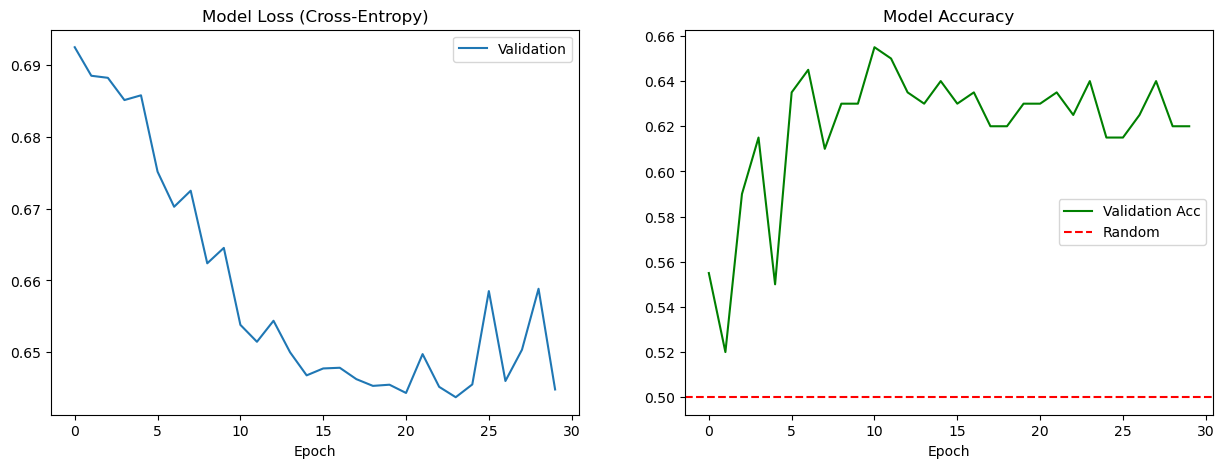

In [60]:
# 1. After training, initialize the evaluator
# Assuming you saved your metrics in 'history_dict'
evaluator = GenomicEvaluator(model, history_dict)

# 2. Show the loss/accuracy plots
evaluator.plot_learning_curves()

## Step 6. Evaluate final results in test data

In [61]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

class GenomicEvaluator:
    def __init__(self, model, device='cpu'):
        self.model = model.to(device)
        self.device = device
        self.history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    def run_test(self, test_loader):
        """Runs the model on unseen test data and returns metrics."""
        self.model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for seqs, labels in test_loader:
                seqs = seqs.to(self.device)
                outputs = self.model(seqs).squeeze()
                preds = (outputs > 0.5).float().cpu().numpy()
                
                all_preds.extend(preds)
                all_labels.extend(labels.numpy())
        
        # Calculate Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print("\n--- Test Set Classification Report ---")
        print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive']))
        
        self._plot_confusion_matrix(cm)

    def _plot_confusion_matrix(self, cm):
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Pred Neg', 'Pred Pos'], 
                    yticklabels=['Actual Neg', 'Actual Pos'])
        plt.title("Confusion Matrix: Enhancer Detection")
        plt.show()

    def plot_saliency_logo(self, sequence_tensor, actual_label):
        """
        Generates a saliency map to visualize 'motifs'.
        The darker the color, the more that specific base influenced the prediction.
        """
        self.model.eval()
        input_tensor = sequence_tensor.unsqueeze(0).to(self.device).requires_grad_(True)
        
        output = self.model(input_tensor)
        self.model.zero_grad()
        output.backward()
        
        # Get gradients and take absolute value
        gradients = input_tensor.grad.data.abs().squeeze().cpu().numpy()
        
        # Plotting a 60bp window (center of the 200bp sequence)
        start, end = 70, 130
        plt.figure(figsize=(18, 3))
        sns.heatmap(gradients[:, start:end], annot=False, cmap="YlOrRd",
                    yticklabels=['A', 'C', 'G', 'T'])
        plt.title(f"Saliency Map (Importance) - Actual Label: {actual_label}")
        plt.xlabel("Genomic Position")
        plt.show()


--- Test Set Classification Report ---
              precision    recall  f1-score   support

    Negative       0.51      0.92      0.65       100
    Positive       0.56      0.10      0.17       100

    accuracy                           0.51       200
   macro avg       0.53      0.51      0.41       200
weighted avg       0.53      0.51      0.41       200



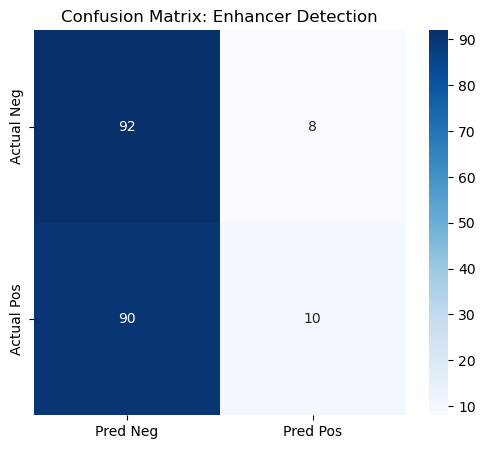

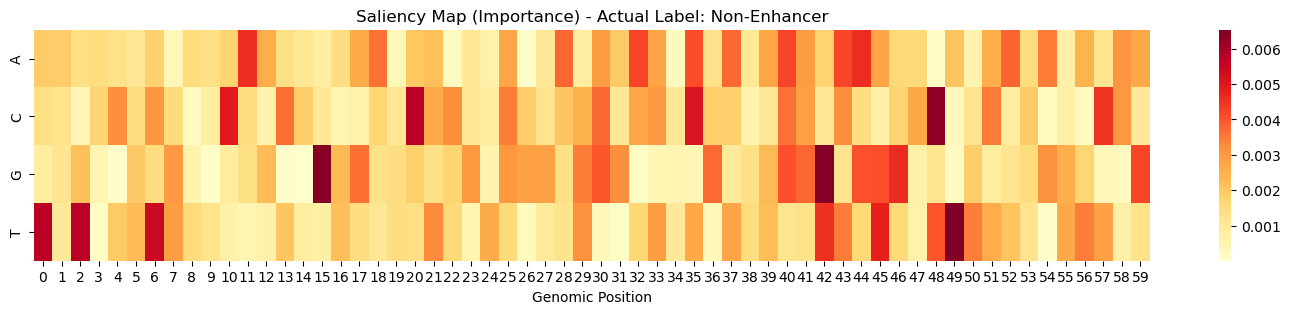

In [62]:
# 1. Initialize the evaluator
eval = GenomicEvaluator(model, device=device)

# 2. Run the full test suite
eval.run_test(test_loader)

# 3. Visualize what a 'Positive' looks like to the model
# Pick a random sample from the test set
sample_seq, sample_label = test_ds[10] 
eval.plot_saliency_logo(sample_seq, "Enhancer" if sample_label == 1 else "Non-Enhancer")